# Set up Conda environment

`conda create --name myenv python=3.10 jupyter openjdk=11 pyspark matplotlib`

`conda activate myenv`

# Open Jupyter notebook

`jupyter notebook`

In [1]:
import pyspark
import random
import time
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [2]:
pyspark.__version__

'3.2.1'

# Check and set Python version

Python version used in the worker and the driver must be the same. This implementation can run on Python 3.10. 

In [4]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Set Spark config variables

In [5]:
conf = pyspark.conf.SparkConf().setAll([
    ('spark.executorEnv.PYSPARK_PYTHON', sys.executable), 
    ('spark.executorEnv.PYSPARK_DRIVER_PYTHON', sys.executable),
    ('spark.workerEnv.PYSPARK_PYTHON', sys.executable),
    ('spark.workerEnv.PYSPARK_DRIVER_PYTHON', sys.executable),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('maximizeResourceAllocation', 'true'),
    ('spark.dynamicAllocation.minExecutors', 1),
    ('spark.dynamicAllocation.maxExecutors', 5),
    ('spark.driver.memory', '10g'),
#     ('spark.executor.instances', 4), # this is not honored in local mode
#     ('spark.executor.cores', 8),
])

# Create Spark session

In [8]:
spark = SparkSession.builder.appName("AM-Join-demo").config(conf=conf).getOrCreate()
spark

# Generate sample data for demo

In [9]:
def generate_data_csv(file_name, spec): # spec: (key, cnt)
    with open(f'{file_name}.csv', 'w') as fhand:
        fhand.write('key,rec\n')
        for tpl in spec:
            # Assign (distinct) random lowercase letter(s) (from a-z) for each key
            recs_ascii = random.sample(range(97, 123), tpl[1])
            for i in range(tpl[1]):
                fhand.write(f'{tpl[0]},{chr(recs_ascii[i])}\n')
    fhand.close()

Sample data for AM-Join

In [10]:
# am_R_spec = [(1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)] # (key, cnt)
# am_S_spec = [(1, 2), (11, 2), (6, 2), (12, 2), (5, 1), (4, 1), (7, 1), (8, 1), (9, 1), (13, 1)]
# generate_data_csv('./data/am_R', am_R_spec)
# generate_data_csv('./data/am_S', am_S_spec)

Sample data for Tree-Join

In [11]:
# tree_R_spec = [(2, 4), (4, 1), (1, 5), (3, 2), (6, 1)]
# tree_S_spec = [(2, 3), (1, 4), (3, 2), (4, 1), (5, 1)]
# generate_data_csv('./data/tree_R', tree_R_spec)
# generate_data_csv('./data/tree_S', tree_S_spec)

# Read data from CSV file

In [12]:
# Read Tree-Join sample data
df_R_tj = spark.read.option('header','true').csv('./data/tree_R.csv', inferSchema=True)
df_S_tj = spark.read.option('header','true').csv('./data/tree_S.csv', inferSchema=True)

# Check schema and show records
df_R_tj.printSchema(), df_R_tj.show()
df_S_tj.printSchema(), df_S_tj.show()

root
 |-- key: integer (nullable = true)
 |-- rec: string (nullable = true)

+---+---+
|key|rec|
+---+---+
|  2|  l|
|  2|  s|
|  2|  d|
|  2|  m|
|  4|  y|
|  1|  v|
|  1|  c|
|  1|  u|
|  1|  e|
|  1|  r|
|  3|  a|
|  3|  z|
|  6|  b|
+---+---+

root
 |-- key: integer (nullable = true)
 |-- rec: string (nullable = true)

+---+---+
|key|rec|
+---+---+
|  2|  l|
|  2|  x|
|  2|  m|
|  1|  j|
|  1|  n|
|  1|  f|
|  1|  g|
|  3|  p|
|  3|  g|
|  4|  c|
|  5|  g|
+---+---+



(None, None)

About RDD: RDD operations are executed in parallel on each partition. 

In [13]:
"""
Util funtions for combineByKey
"""
def to_list(a):
    return [a]
def append(a, b):
    a.append(b)
    return a
def extend(a, b):
    a.extend(b)
    return a

In [14]:
"""
Constants
"""
lmbd = 0.5 # the ratio of network to disk costs, assume 0.5 as value
num_cores = 8 # number of cores in Spark executor

In [15]:
"""
Test function
"""
def test_correctness(actual, expected, skip_record_check=False):
    """
    NOTE: There is a difference in data structure between expected and res, 
    expected: [(key, (val1, val2)), ...]
    res: [(key, val1, val2), ...]
    so we take that into account when testing. 
    """
    assert(len(actual) == len(expected))
    if not skip_record_check: # if not necessary
        for rec in expected:
            assert((rec[0], rec[1][0], rec[1][1]) in actual)
    # No errors means OK. 

# Tree-Join implementation

Implementation of Algorithm 1-6 from the paper. 

In [112]:
def mapBuildJoinedIndex(x, i):
    """
    A map function to mark record from one relation.
    In this implementation, 0 means the record belongs to R and 1 to S. 
    
    ri -> (key, (0, ri))
    sj -> (key, (1, sj))
    
    Input: A tuple x with the format (key, val)
    Output: A tuple with the format(key, (0/1, val))
    """
    return (x[0], (i, x[1]))

In [113]:
def reduceBuildJoinedIndex(x):
    """
    A map function to essentially change the format of the record. 
    
    (key, ((0, ri) OR (1, sj))*) -> (key, ri*, sj*)
    
    Input: A tuple x with the format (key, [[0/1, val], ...]), 
    where a value of either 0 or 1 is used to mark the relation to which the record belongs to. 
    In this implementation, 0 means the record belongs to R and 1 to S. 
    Output: A tuple with the format (key, [val1, ...], [val2, ...]), where tuple[1] is the record marked with 0 and tuple[2] with 1. 
    """
    LR = []
    LS = []
    for tpl in x[1]:
        if tpl[0] == 0:
            LR.append(tpl[1])
        else:
            LS.append(tpl[1])
    return (x[0], LR, LS)

Algorithm 2

In [114]:
def buildJoinedIndex(R, S): # R, S (in RDD) -> joined_index (in RDD)
    """
    A function to build the joined index. 
    
    Input: Two relations to be joined, R and S (in RDD). 
    Output: A joined index mapping each join key to the pair of lists of records. 
    Each element has the format (key, LR, LS), where Li is the list of records from relation i. 
    """
    keyedR = R.map(lambda x: mapBuildJoinedIndex(x, 0)) # ri -> (key, (0, ri))
#     print('keyedR: ', keyedR.collect())
    keyedS = S.map(lambda x: mapBuildJoinedIndex(x, 1)) # sj -> (key, (1, sj))
#     print('keyedS: ', keyedS.collect())
#     joined_index = keyedR.union(keyedS).groupByKey().mapValues(list).map(reduceBuildJoinedIndex) # inefficient
    joined_index = keyedR.union(keyedS).combineByKey(to_list, append, extend).map(reduceBuildJoinedIndex)
#     print('joined_index', joined_index.collect())
    return joined_index

Algorithm 6

In [115]:
def isHotKey(l1, l2): 
    """
    A function to check whether a key is a hot key. 
    
    Input: The length of records li of the checked key in relation i. 
    Output: A boolean on whether the key is a hot key, i.e. whether the list of records of this key should be further chunked. 
    """
    l = math.sqrt(l1 * l2)
    return l > (math.sqrt(1 + math.sqrt(2 + lmbd)) ** 3)

Algorithm 4

In [116]:
def mapGetAllValuePairs(x):
    """
    A map function to essentially get the join results between two relations on a key, with list of records L1 and L2 respectively.
    
    Input: A tuple x with the format (key, [val1, ...], [val2, ...]) where tuple[1] and tuple[2] are the two lists of records from the two relations. 
    Output: A list of the join results. Each element has the format (key, val1, val2) where val1 is the value of the record from one relation, and val2 from the other.
    
    Note: val can be a list depending on the usage. 
    """
    u = []
    key, L1, L2 = x[0], x[1], x[2]
    for val1 in L1:
        for val2 in L2:
            u.append((key, val1, val2))
    return u

Algorithm 5

In [117]:
def chunkList(L): # L is a list of values of a certain key in a certain relation
    """
    A function to divide the list of records into sublists. 
    
    Input: A list L containing the values of the checked key in one relation. 
    Output: A list of sublists of records. 
    """
    l = len(L)
    no_sublist = math.ceil(l ** (1/3))
    len_sublist = math.floor(l / no_sublist)
    res = []
    for i in range(no_sublist):
        start = i * no_sublist
        sublist = []
        j = start
        while (j != start + len_sublist or i == no_sublist - 1) and j < l:
            sublist.append(L[j])
            j += 1
        res.append(sublist)
    return res

In [118]:
def mapChunkPairOfLists(x):
    """
    A map function to assign sublists of records to a key. 
    
    Input: A tuple x with the format (key, [val1, ...], [val2, ...]) where tuple[1] and tuple[2] are the two lists of records from the two relations.
    Output: A tuple with the format (key, [[val1, ...], ...], [[val2, ...], ...]) where tuple[1] and tuple[2] are two lists containing sublists of records from the two relations as a result of chunking. 
    """
    key, L1, L2 = x[0], x[1], x[2]
    return (key, chunkList(L1), chunkList(L2))

Algorithm 3

In [119]:
def treeJoinIteration(joined_index):
    """
    One iteration of Tree-Join, outputs partial join results and new joined index where applicable. 
    
    Input: Joined index with the format [(key, LR, LS), ...], where Li is the list of records from relation i. 
    Output: 
    1) Partial join results on the applicable keys with the format [(key, val1, val2), ...]
    2) New joined index with the format [(key, [val1, ...], [val2, ...])]
    """
#     print('======== NEW TREE JOIN ITERATION ========')
    joined_index_cached = joined_index.cache()
    cold_index = joined_index_cached.filter(lambda x: not isHotKey(len(x[1]), len(x[2])))
    hot_index = joined_index_cached.filter(lambda x: isHotKey(len(x[1]), len(x[2])))
#     print('cold_index: ', cold_index.collect())
#     print('hot_index: ', hot_index.collect())
    partial_join = cold_index.map(mapGetAllValuePairs).filter(lambda x: len(x) > 0).flatMap(lambda x: x)
#     print('partial_join: ', partial_join.collect())
    chunks = hot_index.map(mapChunkPairOfLists)
#     print('chunks: ', chunks.collect())
    new_index = chunks.map(mapGetAllValuePairs).filter(lambda x: len(x) > 0).flatMap(lambda x: x)
#     print('new_index: ', new_index.collect())
    return (partial_join, new_index)

Algorithm 1

First iteration would yield distinct keys in `joined_index`, but next iterations would yield some repeated keys as we deal with hot keys (whose records are further chunked). 

In [120]:
def treeJoin(R, S):
    """
    Main function of Tree-Join. 
    
    Input: Two relations to be joined, R and S (in RDD). 
    Output: The join results with the format [(key, val1, val2), ...]
    """
#     print('R partitions: ', R.getNumPartitions())
#     print('S partitions: ', R.getNumPartitions())
    joined_index = buildJoinedIndex(R, S)
    Q = spark.sparkContext.emptyRDD()
    while joined_index.count() > 0:
        partial_join, new_index = treeJoinIteration(joined_index)
        Q = Q.union(partial_join)
        joined_index = new_index
    return Q

# Run Tree-Join

In [121]:
# Convert DataFrame to RDD
rdd_R_tj = df_R_tj.rdd
rdd_S_tj = df_S_tj.rdd
rdd_R_tj.collect(), rdd_S_tj.collect()

([Row(key=2, rec='l'),
  Row(key=2, rec='s'),
  Row(key=2, rec='d'),
  Row(key=2, rec='m'),
  Row(key=4, rec='y'),
  Row(key=1, rec='v'),
  Row(key=1, rec='c'),
  Row(key=1, rec='u'),
  Row(key=1, rec='e'),
  Row(key=1, rec='r'),
  Row(key=3, rec='a'),
  Row(key=3, rec='z'),
  Row(key=6, rec='b')],
 [Row(key=2, rec='l'),
  Row(key=2, rec='x'),
  Row(key=2, rec='m'),
  Row(key=1, rec='j'),
  Row(key=1, rec='n'),
  Row(key=1, rec='f'),
  Row(key=1, rec='g'),
  Row(key=3, rec='p'),
  Row(key=3, rec='g'),
  Row(key=4, rec='c'),
  Row(key=5, rec='g')])

## Record elapsed time

Note: Comment the print statements first. 

In [122]:
start = time.time()
res_tj = treeJoin(rdd_R_tj, rdd_S_tj).collect()
end = time.time()
print(end - start)

0.4017791748046875


In [78]:
start = time.time()
expected_tj = rdd_R_tj.join(rdd_S_tj).collect()
end = time.time()
print(end - start)

0.14609217643737793


## Check for correctness of result

In [79]:
test_correctness(res_tj, expected_tj)
# No error means OK. 

## Show result

In [80]:
# # Dataframe format
# schema = StructType([
#     StructField('key', IntegerType(), True),
#     StructField('recR', StringType(), True),
#     StructField('recS', StringType(), True),
# ])
# df_res_tj = spark.createDataFrame(res_tj, schema=schema)
# df_res_tj.show()

In [30]:
res_tj

[(2, 'l', 'l'),
 (2, 'l', 'x'),
 (2, 'l', 'm'),
 (2, 's', 'l'),
 (2, 's', 'x'),
 (2, 's', 'm'),
 (2, 'd', 'l'),
 (2, 'd', 'x'),
 (2, 'd', 'm'),
 (2, 'm', 'l'),
 (2, 'm', 'x'),
 (2, 'm', 'm'),
 (4, 'y', 'c'),
 (3, 'a', 'p'),
 (3, 'a', 'g'),
 (3, 'z', 'p'),
 (3, 'z', 'g'),
 (1, 'v', 'j'),
 (1, 'v', 'n'),
 (1, 'c', 'j'),
 (1, 'c', 'n'),
 (1, 'v', 'f'),
 (1, 'v', 'g'),
 (1, 'c', 'f'),
 (1, 'c', 'g'),
 (1, 'u', 'j'),
 (1, 'u', 'n'),
 (1, 'e', 'j'),
 (1, 'e', 'n'),
 (1, 'r', 'j'),
 (1, 'r', 'n'),
 (1, 'u', 'f'),
 (1, 'u', 'g'),
 (1, 'e', 'f'),
 (1, 'e', 'g'),
 (1, 'r', 'f'),
 (1, 'r', 'g')]

# Broadcast-Join

Implementation of Algorithm 7-8 from the paper. 

In [123]:
def mapBuildIndex(x):
    """
    A map function to essentially change the format of the record. 
    
    Input: Record x (in RDD). 
    Output: Record with the format (key, val). 
    """
    return (x[0], x[1])

Algorithm 8

In [124]:
def mapBroadcastJoin(reci, index):
        """
        A map function that executes locally in executors to get the join results. 

        Input: 
        1) A record reci from the non-replicated (non-broadcasted) relation. 
        2) Broadcasted index
        Output: A list of triplets (key, vali, valj) representing the join of x with the broadcasted index. 
        """
        u = []
        key, vali = reci[0], reci[1] # getKey(reci): reci[0]
        if key in index:
            index_key = index[key]
            for valj in index_key:
                u.append((key, vali, valj))
        return u

Algorithm 7

In [125]:
def broadcastJoin(R, S):
    """
    Main function of Broadcast-Join. 
    
    Input: Two relations to be joined, R and S (in RDD). 
    Output: The join results with the format [(key, val1, val2), ...]. 
    """
#     print('R partitions: ', R.getNumPartitions())
#     print('S partitions: ', R.getNumPartitions())
#     index = S.map(mapBuildIndex).groupByKey().mapValues(list).collectAsMap() # inefficient
    index = S.map(mapBuildIndex).combineByKey(to_list, append, extend).collectAsMap()
#     print('index: ', index)
    # Broadcast index
    broadcast_index = spark.sparkContext.broadcast(index)
    Q = R.map(lambda reci: mapBroadcastJoin(reci, broadcast_index.value)).filter(lambda x: len(x) > 0).flatMap(lambda x: x)
    return Q

# Run Broadcast-Join 

In [126]:
# Reuse Tree-Join's sample data
rdd_R_bj = df_R_tj.rdd
rdd_S_bj = df_S_tj.rdd
rdd_R_bj.collect(), rdd_S_bj.collect()

([Row(key=2, rec='l'),
  Row(key=2, rec='s'),
  Row(key=2, rec='d'),
  Row(key=2, rec='m'),
  Row(key=4, rec='y'),
  Row(key=1, rec='v'),
  Row(key=1, rec='c'),
  Row(key=1, rec='u'),
  Row(key=1, rec='e'),
  Row(key=1, rec='r'),
  Row(key=3, rec='a'),
  Row(key=3, rec='z'),
  Row(key=6, rec='b')],
 [Row(key=2, rec='l'),
  Row(key=2, rec='x'),
  Row(key=2, rec='m'),
  Row(key=1, rec='j'),
  Row(key=1, rec='n'),
  Row(key=1, rec='f'),
  Row(key=1, rec='g'),
  Row(key=3, rec='p'),
  Row(key=3, rec='g'),
  Row(key=4, rec='c'),
  Row(key=5, rec='g')])

## Record elapsed time

In [127]:
start = time.time()
res_bj = broadcastJoin(rdd_R_bj, rdd_S_bj).collect()
end = time.time()
print(end - start)

0.14857220649719238


In [128]:
start = time.time()
expected_bj = rdd_R_bj.join(rdd_S_bj).collect()
end = time.time()
print(end - start)

0.12271881103515625


## Check for correctness of result

In [87]:
test_correctness(res_bj, expected_bj)
# No error means OK. 

## Show result

In [38]:
res_bj

[(2, 'l', 'l'),
 (2, 'l', 'x'),
 (2, 'l', 'm'),
 (2, 's', 'l'),
 (2, 's', 'x'),
 (2, 's', 'm'),
 (2, 'd', 'l'),
 (2, 'd', 'x'),
 (2, 'd', 'm'),
 (2, 'm', 'l'),
 (2, 'm', 'x'),
 (2, 'm', 'm'),
 (4, 'y', 'c'),
 (1, 'v', 'j'),
 (1, 'v', 'n'),
 (1, 'v', 'f'),
 (1, 'v', 'g'),
 (1, 'c', 'j'),
 (1, 'c', 'n'),
 (1, 'c', 'f'),
 (1, 'c', 'g'),
 (1, 'u', 'j'),
 (1, 'u', 'n'),
 (1, 'u', 'f'),
 (1, 'u', 'g'),
 (1, 'e', 'j'),
 (1, 'e', 'n'),
 (1, 'e', 'f'),
 (1, 'e', 'g'),
 (1, 'r', 'j'),
 (1, 'r', 'n'),
 (1, 'r', 'f'),
 (1, 'r', 'g'),
 (3, 'a', 'p'),
 (3, 'a', 'g'),
 (3, 'z', 'p'),
 (3, 'z', 'g')]

# IB-FO-Join implementation

Implementation of Algorithm 9-12 from the paper. 

Algorithm 10

In [129]:
def mapBroadcastLeftOuterJoin(reci, index):
    """
    A map function that executes locally in executors to get the left outer join results. 

    Input: 
    1) A record reci from the non-replicated (non-broadcasted) relation. 
    2) Broadcasted index
    Output: A list of triplets (key, vali, valj) representing the join of x with the broadcasted index. 
    """
    u = []
    key, vali = reci[0], reci[1] # getKey(reci): reci[0]
    if key in index:
        index_key = index[key]
        for valj in index_key:
            u.append((key, vali, valj))
    else:
        u.append((key, vali, None))
    return u

Algorithm 11

In [130]:
def mapGetRightJoinableKey(reci, index):
    """
    A map function that executes locally in executors to return the key of a record if it is joinable with broadcast_index. 

    Input: 
    1) A record reci from the non-replicated (non-broadcasted) relation. 
    2) Broadcasted index
    Output: The key of record reci if it is joinable with broadcast_index. 
    """
    u = set()
    key = reci[0] # getKey(reci): reci[0]
    if key in index:
        u.add(key)
    return u

Algorithm 12

In [131]:
def mapRightAntiJoin(recj, keysUnjoinable):
    """
    A map function that executes locally in executors to get the right anti join results. 
    
    Input: 
    1) A record recj from the replicated (broadcasted) relation. 
    2) Broadcasted keys that are unjoined
    Output: The join results of recj if its key is in keysUnjoinable with the format (key, vali, valj). 
    """
    key, valj = recj[0], recj[1] # getKey(recj): recj[0]
    if key in keysUnjoinable:
        return (key, None, valj)
    return ()

Algorithm 9

In [132]:
def indexBroadcastFullOuterJoin(R, S):
    """
    Main function of IB-FO-Join. 
    
    Input: Two relations to be joined, R and S (in RDD). 
    Output: The join results with the format [(key, val1, val2), ...].
    """
#     print('R partitions: ', R.getNumPartitions())
#     print('S partitions: ', R.getNumPartitions())
    
    index = S.map(mapBuildIndex).combineByKey(to_list, append, extend).collectAsMap()
#     print('index: ', index)
    # Broadcast index
    broadcast_index = spark.sparkContext.broadcast(index)
    Q_leftOuter = R.map(lambda reci: mapBroadcastLeftOuterJoin(reci, broadcast_index.value)).flatMap(lambda x: x)
#     print('Q_leftOuter: ', Q_leftOuter.collect())
    unionSet = lambda x, y: x.union(y)
    # A set of keys that have been left-outer-joined
    keysJoined = R.map(lambda reci: mapGetRightJoinableKey(reci, broadcast_index.value)).treeAggregate(set(), unionSet, unionSet)
#     print('keysJoined: ', keysJoined)
    keysUnjoinable = set(broadcast_index.value.keys()) - keysJoined
#     print('keysUnjoinable: ', keysUnjoinable)
    broadcast_keysUnjoinable = spark.sparkContext.broadcast(keysUnjoinable)
    Q_rightAnti = S.map(lambda recj: mapRightAntiJoin(recj, broadcast_keysUnjoinable.value)).filter(lambda x: len(x) > 0)
    return Q_leftOuter.union(Q_rightAnti)

Note to self: Prefer `S.map(mapBuildIndex).combineByKey(to_list, append, extend)` over `S.map(mapBuildIndex).groupByKey().mapValues(list)` for efficiency reasons. 

# Run IB-FO-Join 

In [133]:
# Reuse Tree-Join's sample data
rdd_R_ibfo = df_R_tj.rdd
rdd_S_ibfo = df_S_tj.rdd
rdd_R_ibfo.collect(), rdd_S_ibfo.collect()

([Row(key=2, rec='l'),
  Row(key=2, rec='s'),
  Row(key=2, rec='d'),
  Row(key=2, rec='m'),
  Row(key=4, rec='y'),
  Row(key=1, rec='v'),
  Row(key=1, rec='c'),
  Row(key=1, rec='u'),
  Row(key=1, rec='e'),
  Row(key=1, rec='r'),
  Row(key=3, rec='a'),
  Row(key=3, rec='z'),
  Row(key=6, rec='b')],
 [Row(key=2, rec='l'),
  Row(key=2, rec='x'),
  Row(key=2, rec='m'),
  Row(key=1, rec='j'),
  Row(key=1, rec='n'),
  Row(key=1, rec='f'),
  Row(key=1, rec='g'),
  Row(key=3, rec='p'),
  Row(key=3, rec='g'),
  Row(key=4, rec='c'),
  Row(key=5, rec='g')])

## Record elapsed time

In [134]:
start = time.time()
res_ibfo = indexBroadcastFullOuterJoin(rdd_R_ibfo, rdd_S_ibfo).collect()
end = time.time()
print(end - start)

0.20778799057006836


In [94]:
start = time.time()
expected_ibfo = rdd_R_ibfo.fullOuterJoin(rdd_S_ibfo).collect()
end = time.time()
print(end - start)## Check for correctness of result

0.13074398040771484


## Check for correctness of result

In [95]:
test_correctness(res_ibfo, expected_ibfo)
# No error means OK.

## Show result

In [96]:
res_ibfo

[(2, 'l', 'l'),
 (2, 'l', 'x'),
 (2, 'l', 'm'),
 (2, 's', 'l'),
 (2, 's', 'x'),
 (2, 's', 'm'),
 (2, 'd', 'l'),
 (2, 'd', 'x'),
 (2, 'd', 'm'),
 (2, 'm', 'l'),
 (2, 'm', 'x'),
 (2, 'm', 'm'),
 (4, 'y', 'c'),
 (1, 'v', 'j'),
 (1, 'v', 'n'),
 (1, 'v', 'f'),
 (1, 'v', 'g'),
 (1, 'c', 'j'),
 (1, 'c', 'n'),
 (1, 'c', 'f'),
 (1, 'c', 'g'),
 (1, 'u', 'j'),
 (1, 'u', 'n'),
 (1, 'u', 'f'),
 (1, 'u', 'g'),
 (1, 'e', 'j'),
 (1, 'e', 'n'),
 (1, 'e', 'f'),
 (1, 'e', 'g'),
 (1, 'r', 'j'),
 (1, 'r', 'n'),
 (1, 'r', 'f'),
 (1, 'r', 'g'),
 (3, 'a', 'p'),
 (3, 'a', 'g'),
 (3, 'z', 'p'),
 (3, 'z', 'g'),
 (6, 'b', None),
 (5, None, 'g')]

# AM-Join implementation

Implementation of Algorithm 13-14 from the paper. 

In [135]:
def getHotKeys(L, k):
    """
    A function to get top-k hot keys using approximate distributed heavy hitters Space-Saving algorithm. 
    Recall that this algorithm is an approximation, inaccuracies in the result are expected to some extent. 
    
    Input: The records L from one relation. 
    Output: A list of hot keys with length k. 
    """
    threshold = math.floor(math.sqrt(1 + math.sqrt(2 + lmbd)) ** 3) - 2
    def update_counters(counters, rec):
        key = rec[0]
        if key in counters:
            counters[key] += 1
        elif len(counters) < k:
            counters[key] = 1
        else:
            min_key = min(counters, key=counters.get)
            min_cnt = counters[min_key]
            # Check if the count is above threshold
            if min_cnt < threshold:
                counters[key] = 1
                del counters[min_key]
        return counters
    def merge_counters(counters1, counters2):
        merged_counters = defaultdict(int)
        for key, cnt in counters1.items():
            merged_counters[key] += cnt
        for key, cnt in counters2.items():
            merged_counters[key] += cnt
        return dict(merged_counters)
    merged_counters = L.aggregate(defaultdict(int), update_counters, merge_counters)
    return set(merged_counters.keys())

In [136]:
def getNumHotKeys(L):
    """
    A function that returns the maximum number of hot keys that should come out of records L.
    
    Input: The records L from one relation. 
    Output: The maximum number of hot keys.
    """
    return math.ceil(L.count() / (math.sqrt(1 + math.sqrt(2 + lmbd)) ** 3))

In [137]:
def splitRelationPartitions(L, K):
    """
    A function that splits the relation L based on whether its key belong to a set of keys K. 
    
    Input: The records L from one relation. 
    Output: Two split records LH, which matches the set of keys K, and LC, which does not. 
    """
    L_cached = L.cache()
    LH = L_cached.filter(lambda rec: rec[0] in K)
    LC = L_cached.filter(lambda rec: rec[0] not in K)
    return (LH, LC)

Algorithm 13

In [138]:
def splitRelations(R, KR, KS):
    """
    A function that splits the relation R based on the hot keys KR and KS. 
    
    Input: A relation R to be split, and the hot keys KR and KS. 
    Output: The four splits of R. 
    """
    RH, RC = splitRelationPartitions(R, KR)
    RHH, RHC = splitRelationPartitions(RH, KS)
    RCH, RCC = splitRelationPartitions(RC, KS)
    return (RHH, RHC, RCH, RCC)

In [139]:
def mapSwapJoinedRecords(x):
    """
    A map function to swap column values.
    
    Input: A record x. 
    Output: The record x with swapped column values. 
    """
    return (x[0], x[2], x[1])

In [140]:
def mapFormatSparkJoinedRecords(x):
    """
    A map function to format records that resulted from a join operation by Spark.
    
    Input: A record x. 
    Output: The formatted record x. 
    """
    return (x[0], x[1][0], x[1][1]) 

Algorithm 13

In [141]:
def amJoin(R, S):
    """
    Main function of AM-Join. 
    
    Input: Two relations to be joined, R and S (in RDD). 
    Output: The join results with the format [(key, val1, val2), ...].
    """
#     print('R partitions: ', R.getNumPartitions())
#     print('S partitions: ', R.getNumPartitions())
    kR = getNumHotKeys(R)
    KR = getHotKeys(R, kR)
    kS = getNumHotKeys(S)
    KS = getHotKeys(S, kS)
#     print('kR: ', kR)
#     print('KR: ', KR)
#     print('kS: ', kS)
#     print('KS: ', KS)
    RHH, RHC, RCH, RCC = splitRelations(R, KR, KS)
    SHH, SHC, SCH, SCC = splitRelations(S, KS, KR)
#     print('RHH: ', RHH.collect())
#     print('RHC: ', RHC.collect())
#     print('RCH: ', RCH.collect())
#     print('RCC: ', RCC.collect())
#     print('SHH: ', SHH.collect())
#     print('SHC: ', SHC.collect())
#     print('SCH: ', SCH.collect())
#     print('SCC: ', SCC.collect())
    # (RHH x SHH) U (RHC x SCH) U (SHC x RCH) U (RCC x SCC)
    Q = treeJoin(RHH, SHH).union(broadcastJoin(RHC, SCH)).union(broadcastJoin(SHC, RCH).map(mapSwapJoinedRecords)).union(RCC.join(SCC).map(mapFormatSparkJoinedRecords))
    return Q

In [142]:
# Read AM-Join sample data
df_R_am =spark.read.option('header','true').csv('./data/am_R.csv', inferSchema=True)
df_S_am = spark.read.option('header','true').csv('./data/am_S.csv', inferSchema=True)
df_R_am.show(), df_S_am.show()

+---+---+
|key|rec|
+---+---+
|  1|  e|
|  1|  q|
|  2|  c|
|  2|  e|
|  3|  t|
|  3|  e|
|  4|  s|
|  4|  k|
|  5|  w|
|  6|  c|
|  7|  r|
|  8|  n|
|  9|  q|
| 10|  r|
+---+---+

+---+---+
|key|rec|
+---+---+
|  1|  x|
|  1|  j|
| 11|  q|
| 11|  n|
|  6|  h|
|  6|  b|
| 12|  t|
| 12|  g|
|  5|  m|
|  4|  p|
|  7|  d|
|  8|  v|
|  9|  h|
| 13|  y|
+---+---+



(None, None)

# Run AM-Join

In [143]:
rdd_R_am = df_R_am.rdd
rdd_S_am = df_S_am.rdd
rdd_R_am.collect(), rdd_S_am.collect()

([Row(key=1, rec='e'),
  Row(key=1, rec='q'),
  Row(key=2, rec='c'),
  Row(key=2, rec='e'),
  Row(key=3, rec='t'),
  Row(key=3, rec='e'),
  Row(key=4, rec='s'),
  Row(key=4, rec='k'),
  Row(key=5, rec='w'),
  Row(key=6, rec='c'),
  Row(key=7, rec='r'),
  Row(key=8, rec='n'),
  Row(key=9, rec='q'),
  Row(key=10, rec='r')],
 [Row(key=1, rec='x'),
  Row(key=1, rec='j'),
  Row(key=11, rec='q'),
  Row(key=11, rec='n'),
  Row(key=6, rec='h'),
  Row(key=6, rec='b'),
  Row(key=12, rec='t'),
  Row(key=12, rec='g'),
  Row(key=5, rec='m'),
  Row(key=4, rec='p'),
  Row(key=7, rec='d'),
  Row(key=8, rec='v'),
  Row(key=9, rec='h'),
  Row(key=13, rec='y')])

## Record elapsed time

In [144]:
start = time.time()
res_am = amJoin(rdd_R_am, rdd_S_am).collect()
end = time.time()
print(end - start)

0.79380202293396


In [109]:
start = time.time()
expected_am = rdd_R_am.join(rdd_S_am).collect()
end = time.time()
print(end - start)

0.11641287803649902


## Check for correctness of result

In [110]:
test_correctness(res_am, expected_am)
# No error means OK.

## Show result

In [111]:
res_am

[(1, 'e', 'x'),
 (1, 'e', 'j'),
 (1, 'q', 'x'),
 (1, 'q', 'j'),
 (4, 's', 'p'),
 (4, 'k', 'p'),
 (6, 'c', 'h'),
 (6, 'c', 'b'),
 (8, 'n', 'v'),
 (5, 'w', 'm'),
 (7, 'r', 'd'),
 (9, 'q', 'h')]

# Experiments

## Details

### Datasets
* First variant on **size**
     - Record size: 10^3, 10^4, 10^5, 10^6, 10^7, 10^8 records
     - Keys: Selected from uniform distribution with domain size of 2^32 (32-bit integer space)
* Second variant on **skewness**
     - Record size: 10^3 records
     - Keys: Selected from zipf-a distribution with domain size 10^2, with a values of 1.2, 1.4, 1.6, 1.8
### Join algorithms
- Tree-Join
- Broadcast-Join
- AM-Join
### Scenarios
- Increasing record size
- Increasing skewness
- Increasing number of cores

### Metrics
- Execution time

In [62]:
def generate_data_spec_zipf_key(alpha, record_size, domain_size):
    sample = np.random.zipf(alpha, record_size)
    sample = np.clip(sample, 1, domain_size)
    keys, cnts = np.unique(sample, return_counts=True)
    return (keys, cnts)

In [63]:
def generate_data_spec_uniform_key(record_size, domain_size):
    sample = np.random.randint(1, domain_size, record_size)
    keys, cnts = np.unique(sample, return_counts=True)
    return (keys, cnts)

In [64]:
def generate_experiment_data_csv(file_name, spec, max_sample_value=None): # spec: [key, ...], [cnt[key], ...]
    with open(f'{file_name}.csv', 'w') as fhand:
        fhand.write('key,rec\n')
        keys, cnts = spec[0], spec[1]
        if max_sample_value == None:
            max_sample_value = max(cnts) + 1
        for i in range(len(keys)):
            # Assign (distinct) random number(s) for each key
            recs = random.sample(range(1, max_sample_value), cnts[i])
            for j in range(cnts[i]):
                fhand.write(f'{keys[i]},{recs[j]}\n')
    fhand.close()

## First variant of dataset

In [65]:
first_spec_R = generate_data_spec_uniform_key(100000, 2 ** 31)
first_spec_S = generate_data_spec_uniform_key(100000, 2 ** 31)
first_spec_R

(array([     18305,      36138,      71279, ..., 2147455359, 2147456763,
        2147473075]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [66]:
# Generate CSV files
data_sizes = [1000, 10000, 100000, 1000000, 10000000, 100000000]
# for size in data_sizes:
#     generate_experiment_data_csv(f'./data/first-R-{size}', first_spec_R, size)
#     generate_experiment_data_csv(f'./data/first-S-{size}', first_spec_S, size)

## Second variant of dataset

In [73]:
alphas = [1.2, 1.4, 1.6, 1.8, 2]
second_specs_R = [None] * len(alphas)
second_specs_S = [None] * len(alphas)
for i in range(len(alphas)):
    second_specs_R[i] = generate_data_spec_zipf_key(alphas[i], 1000, 100)
    second_specs_S[i] = generate_data_spec_zipf_key(alphas[i], 1000, 100)
second_specs_R

[(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
          27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
          40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  51,  52,  53,
          54,  55,  56,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,
          69,  72,  73,  74,  75,  77,  78,  80,  83,  86,  87,  88,  90,
          91,  92,  96,  97,  99, 100]),
  array([166,  77,  49,  24,  27,  23,  15,  16,  10,  10,  12,   4,   9,
          12,   8,   9,   5,   1,   5,   4,   2,   7,   2,   4,   6,   4,
           3,   3,   5,   6,   1,   5,   1,   2,   1,   3,   3,   3,   3,
           2,   1,   3,   6,   3,   3,   4,   1,   1,   2,   1,   3,   2,
           3,   1,   2,   1,   2,   2,   1,   1,   3,   1,   2,   2,   1,
           2,   1,   1,   1,   2,   1,   1,   3,   1,   2,   1,   1,   1,
           1,   1,   1,   1,   3, 371])),
 (array([  1,   2,   3,   4, 

In [74]:
# # Generate CSV files
# for i, spec in enumerate(second_specs_R):
#     generate_experiment_data_csv(f'./data/second-R-{alphas[i]}', spec)
# for i, spec in enumerate(second_specs_S):
#     generate_experiment_data_csv(f'./data/second-S-{alphas[i]}', spec)

## Conduct experiment

1. On increasing size

In [81]:
def experiment_on_size(sizes, res):
    for size in sizes:
        
        print("Size: ", size)
        
        # Read data
        df_R = spark.read.option('header','true').csv(f'./data/first-R-{size}.csv', inferSchema=True)
        df_S = spark.read.option('header','true').csv(f'./data/first-S-{size}.csv', inferSchema=True)
        rdd_R = df_R.rdd.partitionBy(num_cores)
        rdd_S = df_S.rdd.partitionBy(num_cores)
        
        # Tree-Join
        start = time.time()
        res_tj = treeJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("Tree-Join")
        print(end - start)
        res['tj'].append(end - start)
        
        # Broadcast-Join
        start = time.time()
        res_bj = broadcastJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("Broadcast-Join")
        print(end - start)
        res['bj'].append(end - start)
        
        # AM-Join
        start = time.time()
        res_am = amJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("AM-Join")
        print(end - start)
        res['am'].append(end - start)
        
    return res

In [82]:
exp_res_size = {'tj': [], 'bj': [], 'am': []}
exp_res_size = experiment_on_size(data_sizes, exp_res_size)
exp_res_size

Size:  1000
Tree-Join
1.003870964050293
Broadcast-Join
0.38605189323425293


23/05/23 17:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:35:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
2.0946848392486572
Size:  10000
Tree-Join
1.0811488628387451
Broadcast-Join
0.38468289375305176


23/05/23 17:35:40 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:35:41 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
1.957948923110962
Size:  100000
Tree-Join
0.944767951965332
Broadcast-Join
0.39436817169189453


23/05/23 17:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:35:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
2.015888214111328
Size:  1000000
Tree-Join
0.9394638538360596
Broadcast-Join
0.3765299320220947


23/05/23 17:35:47 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:35:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
2.0880188941955566
Size:  10000000
Tree-Join
1.1482601165771484
Broadcast-Join
0.39577484130859375


23/05/23 17:35:51 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:35:52 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
1.9517302513122559
Size:  100000000
Tree-Join
0.9783999919891357
Broadcast-Join
0.37242698669433594


23/05/23 17:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:35:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
1.998175859451294


{'tj': [1.003870964050293,
  1.0811488628387451,
  0.944767951965332,
  0.9394638538360596,
  1.1482601165771484,
  0.9783999919891357],
 'bj': [0.38605189323425293,
  0.38468289375305176,
  0.39436817169189453,
  0.3765299320220947,
  0.39577484130859375,
  0.37242698669433594],
 'am': [2.0946848392486572,
  1.957948923110962,
  2.015888214111328,
  2.0880188941955566,
  1.9517302513122559,
  1.998175859451294]}

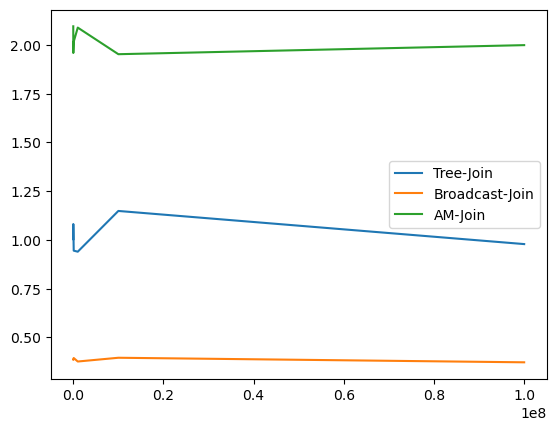

In [84]:
plt.plot(data_sizes, exp_res_size['tj'], label="Tree-Join")
plt.plot(data_sizes, exp_res_size['bj'], label="Broadcast-Join")
plt.plot(data_sizes, exp_res_size['am'], label="AM-Join")
plt.legend()
plt.show()

2. On increasing skewness

In [89]:
def experiment_on_skewness(alphas, res):
    for alpha in alphas:
        
        print("Alpha: ", alpha)
        
        # Read data
        df_R = spark.read.option('header','true').csv(f'./data/second-R-{alpha}.csv', inferSchema=True)
        df_S = spark.read.option('header','true').csv(f'./data/second-S-{alpha}.csv', inferSchema=True)
        rdd_R = df_R.rdd.partitionBy(num_cores)
        rdd_S = df_S.rdd.partitionBy(num_cores)
        
        # Tree-Join
        start = time.time()
        res_tj = treeJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("Tree-Join")
        print(end - start)
        res['tj'].append(end - start)
        
        # Broadcast-Join
        start = time.time()
        res_bj = broadcastJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("Broadcast-Join")
        print(end - start)
        res['bj'].append(end - start)
        
        # AM-Join
        start = time.time()
        res_am = amJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("AM-Join")
        print(end - start)
        res['am'].append(end - start)
    return res

In [90]:
exp_res_skewness = {'tj': [], 'bj': [], 'am': []}
exp_res_skewness = experiment_on_skewness(alphas, exp_res_skewness)
exp_res_skewness

Alpha:  1.2


Tree-Join
9.067851066589355
Broadcast-Join
0.2010810375213623


AM-Join
9.778332948684692
Alpha:  1.4


Tree-Join
9.678820848464966
Broadcast-Join
0.19600415229797363


AM-Join
10.281280994415283
Alpha:  1.6


Tree-Join
16.509501934051514
Broadcast-Join
0.223311185836792


AM-Join
17.060347080230713
Alpha:  1.8


Tree-Join
26.871446132659912
Broadcast-Join
0.26541805267333984


AM-Join
26.097058057785034
Alpha:  2


Tree-Join
35.25183081626892
Broadcast-Join
0.2804880142211914


AM-Join
35.770018100738525


{'tj': [9.067851066589355,
  9.678820848464966,
  16.509501934051514,
  26.871446132659912,
  35.25183081626892],
 'bj': [0.2010810375213623,
  0.19600415229797363,
  0.223311185836792,
  0.26541805267333984,
  0.2804880142211914],
 'am': [9.778332948684692,
  10.281280994415283,
  17.060347080230713,
  26.097058057785034,
  35.770018100738525]}

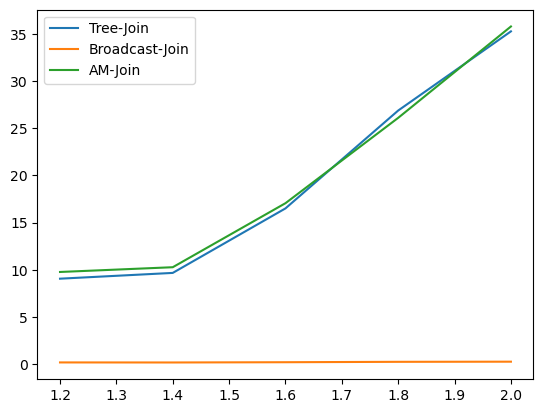

In [92]:
plt.plot(alphas, exp_res_skewness['tj'], label="Tree-Join")
plt.plot(alphas, exp_res_skewness['bj'], label="Broadcast-Join")
plt.plot(alphas, exp_res_skewness['am'], label="AM-Join")
plt.legend()
plt.show()

3. On increasing number of cores (to simulate multiple executors)

In [97]:
def experiment_on_num_cores(ncs, res):
    for nc in ncs:
        
        print("Number of cores: ", nc)
        
        # Read data
        df_R = spark.read.option('header','true').csv(f'./data/first-R-10000.csv', inferSchema=True)
        df_S = spark.read.option('header','true').csv(f'./data/first-S-10000.csv', inferSchema=True)
        rdd_R = df_R.rdd.partitionBy(nc)
        rdd_S = df_S.rdd.partitionBy(nc)
        
        # Tree-Join
        start = time.time()
        res_tj = treeJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("Tree-Join")
        print(end - start)
        res['tj'].append(end - start)
        
        # Broadcast-Join
        start = time.time()
        res_bj = broadcastJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("Broadcast-Join")
        print(end - start)
        res['bj'].append(end - start)
        
        # AM-Join
        start = time.time()
        res_am = amJoin(rdd_R, rdd_S).collect()
        end = time.time()
        print("AM-Join")
        print(end - start)
        res['am'].append(end - start)
    return res

In [100]:
ncs = [i for i in range(1, 9)]
exp_res_num_cores = {'tj': [], 'bj': [], 'am': []}
exp_res_num_cores = experiment_on_num_cores(ncs, exp_res_num_cores)
exp_res_num_cores

Number of cores:  1
Tree-Join
1.1430962085723877
Broadcast-Join
0.6538190841674805


AM-Join
86.77742600440979
Number of cores:  2
Tree-Join
0.7157533168792725
Broadcast-Join
0.44026613235473633


23/05/23 17:58:56 WARN DAGScheduler: Broadcasting large task binary with size 1928.1 KiB


AM-Join
39.66380214691162
Number of cores:  3
Tree-Join
0.68044114112854
Broadcast-Join
0.42505979537963867


23/05/23 17:59:10 WARN DAGScheduler: Broadcasting large task binary with size 1434.1 KiB
23/05/23 17:59:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


AM-Join
13.078643798828125
Number of cores:  4
Tree-Join
0.7883431911468506
Broadcast-Join
0.3701789379119873


23/05/23 17:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1905.3 KiB
23/05/23 17:59:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


AM-Join
3.287956953048706
Number of cores:  5
Tree-Join
0.8925609588623047
Broadcast-Join
0.4302098751068115


23/05/23 17:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:59:19 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
1.7231159210205078
Number of cores:  6
Tree-Join
0.8933677673339844
Broadcast-Join
0.396953821182251


23/05/23 17:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:59:22 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
1.8032732009887695
Number of cores:  7
Tree-Join
0.9025981426239014
Broadcast-Join
0.4370689392089844


23/05/23 17:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:59:26 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
1.9363813400268555
Number of cores:  8
Tree-Join
1.1404039859771729
Broadcast-Join
0.4789109230041504


23/05/23 17:59:29 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/05/23 17:59:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


AM-Join
2.199312210083008


{'tj': [1.1430962085723877,
  0.7157533168792725,
  0.68044114112854,
  0.7883431911468506,
  0.8925609588623047,
  0.8933677673339844,
  0.9025981426239014,
  1.1404039859771729],
 'bj': [0.6538190841674805,
  0.44026613235473633,
  0.42505979537963867,
  0.3701789379119873,
  0.4302098751068115,
  0.396953821182251,
  0.4370689392089844,
  0.4789109230041504],
 'am': [86.77742600440979,
  39.66380214691162,
  13.078643798828125,
  3.287956953048706,
  1.7231159210205078,
  1.8032732009887695,
  1.9363813400268555,
  2.199312210083008]}

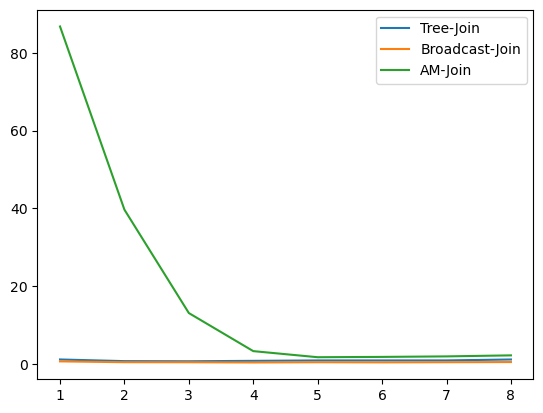

In [102]:
plt.plot(ncs, exp_res_num_cores['tj'], label="Tree-Join")
plt.plot(ncs, exp_res_num_cores['bj'], label="Broadcast-Join")
plt.plot(ncs, exp_res_num_cores['am'], label="AM-Join")
plt.legend()
plt.show()

# Algorithm correctness

Test for correctness of:
1. Tree-Join
2. Broadcast-Join
3. IB-FO-Join
4. AM-Join

on dataset with the largest size: 10^8 records. 

In [ ]:
# Read dataset with largest size
df_R_large = spark.read.option('header','true').csv(f'./data/first-R-100000000.csv', inferSchema=True)
df_S_large = spark.read.option('header','true').csv(f'./data/first-S-100000000.csv', inferSchema=True)
rdd_R_large = df_R_large.rdd.partitionBy(num_cores)
rdd_S_large = df_S_large.rdd.partitionBy(num_cores)

In [ ]:
# Expected results
expected_ij_large = rdd_R_large.join(rdd_S_large).collect()
expected_foj_large = rdd_R_large.fullOuterJoin(rdd_S_large).collect()

1. Tree-Join

In [ ]:
res_tj_large = treeJoin(rdd_R_large, rdd_S_large).collect()
test_correctness(res_tj_large, expected_ij_large)
# No error means OK.

2. Broadcast-Join

In [115]:
res_bj_large = broadcastJoin(rdd_R_large, rdd_S_large).collect()
test_correctness(res_bj_large, expected_ij_large)
# No error means OK.2. Broadcast-Join

3. IB-FO-Join

In [ ]:
res_ibfo_large = indexBroadcastFullOuterJoin(rdd_R_large, rdd_S_large).collect()
test_correctness(res_ibfo_large, expected_foj_large, True) # skip_record_check=True to save time
# No error means OK.

4. AM-Join

In [ ]:
res_am_large = amJoin(rdd_R_large, rdd_S_large).collect()
test_correctness(res_am_large, expected_ij_large)
# No error means OK.2. Broadcast-Join